<a href="https://colab.research.google.com/github/pablohd10/P2.1-RRNN/blob/main/P2.1_RRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

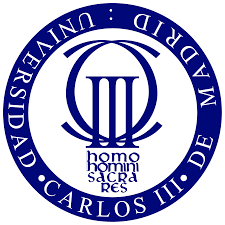


# PRÁCTICA 2.1: REDES DE NEURONAS
---

Autores: Pablo Hidalgo Delgado y Marcos Caballero Cortés   

NIAs: 100451225 y 100451047


## 1. Introducción.
El propósito de esta práctica es abordar un problema de clasificación clásico haciendo uso del Perceptrón Multicapa (PM).

Para ello, se nos dispone de un conjunto de datos desbalanceado sobre las trayectorias de diferentes individuos
en distintos medios de transporte.

Utilizando estos datos, debemos generar un modelo capaz de clasificar el medio de transporte en el que se desplaza un individuo.




## 2. Leer los conjuntos de datos


En primer lugar, importamos todas las librerías que se van a utilizar a lo largo de la práctica.

In [1]:
import random
import time
import pickle
import seaborn as sns


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import table

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Leemos el conjunto de datos proporcionado.

In [2]:
archivo_csv = 'dataRRNN2.csv'

datos = pd.DataFrame()

# Leemos el archivo
datos = pd.read_csv(archivo_csv)

## 3. Análisis Exploratorio de Datos (EDA)
Antes de empezar con la división en datos de entrenamiento y test, vamos a realizar un pequeño análisis exploratorio de datos (EDA). De esta manera, podremos investigar y resumir las características más importantes de nuestro dataset. Esto nos servirá para comprender mejor los datos y optimizar la obtención de nuestro modelo.


### 3.1 Información básica

In [3]:
datos.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29151 entries, 0 to 29150
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    29151 non-null  float64
 1   track_id                   29151 non-null  float64
 2   mean_delta_times           29151 non-null  float64
 3   std_delta_times            29151 non-null  float64
 4   mean_hours                 29151 non-null  float64
 5   std_hours                  29151 non-null  float64
 6   mean_distances             29151 non-null  float64
 7   std_distances              29151 non-null  float64
 8   mean_velocities            29151 non-null  float64
 9   std_velocities             29151 non-null  float64
 10  mean_accelerations         29151 non-null  float64
 11  std_accelerations          29151 non-null  float64
 12  mean_headings              29151 non-null  float64
 13  std_headings               29151 non-null  flo

El conjunto de datos se compone de 29151 instancias y 22 atributos de tipo float64. La variable de salida, label, es de tipo int64.

También podemos observar que no existen columnas que contengan valores nulos.

### 3.2 Atributos irrelevantes
En el apartado anterior identificamos las columnas user_id y track_id que parecen ser identificadores.


In [4]:
print(datos.head(5))

   user_id      track_id  mean_delta_times  std_delta_times  mean_hours  \
0     52.0  2.008071e+13          4.954975         0.304779         4.0   
1     52.0  2.008071e+13          4.890226         1.373293         4.0   
2    167.0  2.008081e+13          2.000000         0.000000         1.0   
3    167.0  2.008081e+13          2.000000         0.000000         1.0   
4    167.0  2.008081e+13          2.000000         0.000000         1.0   

   std_hours  mean_distances  std_distances  mean_velocities  std_velocities  \
0        0.0        7.370991       2.830568         1.475115        0.564191   
1        0.0        4.358587       3.252789         0.833067        0.604174   
2        0.0        2.298434       1.164979         1.149217        0.582489   
3        0.0        2.135659       0.579179         1.067830        0.289589   
4        0.0        0.321824       0.596578         0.160912        0.298289   

   ...  std_headings  mean_heading_changes  std_heading_changes  \
0

Los identificadores no aportan información predictiva para el modelo.

Por esta razón, eliminamos este atributo de nuestro conjunto de datos sin que exista riesgo de fuga de información.

In [5]:
datos.drop(['user_id', 'track_id'], axis=1, inplace=True)

### 3.2 Atributos compuestos de valores constantes

A continuación, vamos a analizar si existen columnas constantes en nuestro conjunto de datos. En ese caso, podremos eliminarlas de nuestro dataset ya que no aportan ninguna información a la variable de respuesta y no existe riesgo de information leakage.

In [6]:
# Eliminamos las columnas con solo un valor único
columnas_constantes = []
for col in datos.columns:
    if datos[col].nunique() == 1:
        print(col)
        columnas_constantes.append(col)
if len(columnas_constantes) == 0:
  print("No existen atributos con valores constantes")

No existen atributos con valores constantes


### 3.3 Distribución de clases
Aunque el enunciado ya indica que los datos presentan desbalanceo, es fundamental confirmar esta característica, así como observar y analizar la distribución de las clases.

0    10899
1     5543
2     6558
3     4403
4     1748
Name: label, dtype: int64


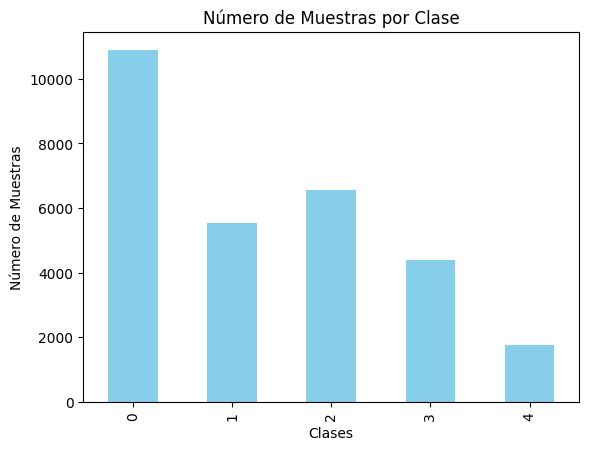

In [7]:
# Calculamos el recuento de muestras por clase y ordenamos por índice (las clases)
conteo_clases = datos['label'].value_counts().sort_index()

# Creamos la gráfica de barras
conteo_clases.plot(kind='bar', color='skyblue')
print(conteo_clases)
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Número de Muestras por Clase')
plt.show()

Vemos el claro desbalanceo de los datos teniendo la clase 0 (andando) bastante más muestras que las demás, en especial que la clase 4 (en metro).

## 5. Preproceso
Previamente a entrenar los modelos, debemos realizar una transformación de los datos para que puedan ser interpretados por el algoritmo de manera eficiente. Las transformaciones de datos que realizamos son las siguientes:

### 5.1 División de datos en train, validation y test.
Una vez explorado y analizado nuestro conjunto de datos, dividimos el dataset en conjuntos de entrenamiento (train), prueba (test) y validación (validation). Para ello, utilizamos la función train_test_split de la librería sklearn.

Dividimos los datos en 2/3 para train y 1/3 para test. El conjunto de validación se corresponderá con un 20% del conjunto de entrenamiento tal y como se nos pide en el enunciado de la práctica.

Antes de realizar la división, debemos separar la variable de respuesta del resto del conjunto de datos.

In [8]:
X = datos.drop("label", axis = 1)
y = datos["label"]

Dividimos el conjunto de datos. Lo hacemos especificando el parámetro suffle = True para que se aleatorizen los datos.

Además, al tratarse de un problema desbalanceado, utilizamos el parámetro stratify para realizar una partición estratificada, es decir, mantener la misma proporción de clases en ambos conjuntos.

También especificamos la semilla random_state a 40 para que los resultados sean reproducibles.



In [9]:
# Dividimos los datos originales en conjuntos de entrenamiento (2/3) y prueba (1/3%)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=1/3, random_state=40, shuffle = True, stratify=y)

# Dividimos el conjunto de entrenamiento en conjuntos de entrenamiento (80%) y validación (20%)
X_train_raw, X_validation_raw, y_train_raw, y_validation_raw = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=40, shuffle = True, stratify=y_train_raw)

# Guardamos los conjuntos de datos en archivos CSV
X_train_raw.to_csv('X_train_raw.csv', index=False)
y_train_raw.to_csv('y_train_raw.csv', index=False)
X_validation_raw.to_csv('X_validation_raw.csv', index=False)
y_validation_raw.to_csv('y_validation_raw.csv', index=False)
X_test_raw.to_csv('X_test_raw.csv', index=False)
y_test_raw.to_csv('y_test_raw.csv', index=False)

Verificamos que existen muestras de cada clase en cada conjunto de datos. Se deberá obtener la misma proporción que se obtuvo con el conjunto de datos entero.

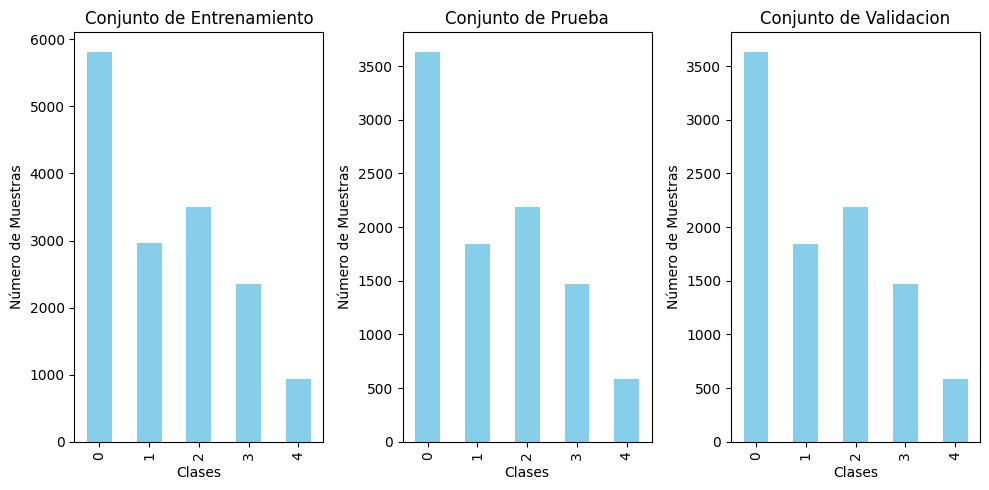

In [10]:
# Verificamos el balance de clases en los conjuntos de entrenamiento, prueba y validación
conteo_clases_train = y_train_raw.value_counts().sort_index()
conteo_clases_test = y_test_raw.value_counts().sort_index()
conteo_clases_validation = y_validation_raw.value_counts().sort_index()

# Creamos la gráfica de barras para los conjuntos de entrenamiento y prueba
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
conteo_clases_train.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Entrenamiento')

plt.subplot(1, 3, 2)
conteo_clases_test.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Prueba')


plt.subplot(1, 3, 3)
conteo_clases_test.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Validacion')

plt.tight_layout()
plt.show()

### 5.2 Aleatorización
La aleatorización de los datos la hemos realizado al dividir el conjunto de datos en train, test y validation al especificar el parametro shuffle = True.

### 5.3 Codificación de la variable de salida
Al estar frente a un problema de clasificación multiclase (5 clases distintas) es importante codificar estos valores para asegurar la compatibilidad con el Perceptrón Multicapa. Para ello, utilizamos la clase LabelBinarizer de scikit learn.

In [11]:
print("Sin codificar:\n", y_train_raw, "\n")
# Binarizamos la variable de salida usando LabelBinarizer
label_binarizer = LabelBinarizer()

# Binarizamos y_train
y_train_binarized = label_binarizer.fit_transform(y_train_raw)

# Binarizamos y_validation
y_validation_binarized = label_binarizer.transform(y_validation_raw)

# Binarizamos y_test
y_test_binarized = label_binarizer.transform(y_test_raw)
print("Codificado: \n", y_train_binarized)

Sin codificar:
 25688    0
22960    0
12721    3
4071     1
708      2
        ..
1535     0
20962    0
10501    3
27156    2
4968     3
Name: label, Length: 15547, dtype: int64 

Codificado: 
 [[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 ...
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]


### 5.4 Normalización
Para que no se produzca information leakage y no dar información al conjunto de test, normalizamos todos los datos con el mínimo y máximo obtenido del conjunto de entrenamiento.

In [12]:
X_train = X_train_raw
X_validation = X_validation_raw
X_test = X_test_raw

# Normalizamos X
for columna in X_train_raw:
 # Obtenemos el minimo y el maximo de cada columna del conjunto de train
  min = X_train_raw[columna].min()
  max = X_train_raw[columna].max()
  # Conjunto de entrenamiento
  X_train[columna] = (X_train_raw[columna] - min)/(max - min)
  # Conjunto de validación
  X_validation[columna] = (X_validation_raw[columna] - min)/(max - min)
  # Conjunto de test
  X_test[columna] = (X_test_raw[columna] - min)/(max - min)

# Normalizamos y (en realidad no es necesario ya que al estar codificado en OHE solo habrá 0 y 1 y el resultado será el mismo)
y_min = y_train_binarized.min()
y_max = y_train_binarized.max()
# Conjunto de entrenamiento
y_train = (y_train_binarized - y_min)/(y_max - y_min)
# Conjunto de validación
y_validation = (y_validation_binarized - y_min)/(y_max - y_min)
# Conjunto de test
y_test = (y_test_binarized - y_min)/(y_max - y_min)

# Guardamos los conjuntos de datos en archivos CSV
X_train.to_csv('X_train.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
X_validation.to_csv('X_validation.csv', index=False)
pd.DataFrame(y_validation).to_csv('y_validation.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

## 6. Perceptrón Multicapa

### 6.1 Implementación

In [13]:
input_shape=(X_train.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla.

def build_and_train_mlp(learning_rate, num_hidden_layers, num_neurons, activation_function, epochs, patience=6, balance_classes=False):
    model = Sequential()

    # Capa de entrada
    model.add(Dense(num_neurons[0], activation=activation_function, input_shape=input_shape))

    # Capas ocultas
    for i in range(1, num_hidden_layers):
        model.add(Dense(num_neurons[i], activation=activation_function))

    # Capa de salida (5 clases --> 5 neuronas)
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0), metrics=['mse'])

    # Calculamos los pesos de clase para el balanceo si es necesario
    if balance_classes:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_raw), y=y_train_raw) # Especificamos las clases sin codificarlas con el OHE
        class_weight_dict = dict(enumerate(class_weights))
    else:
        class_weight_dict = None

    # Definimos el criterio de parada Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True) # Especificamos la paciencia introducida como parámetro y que se restauren automáticamente los pesos a la mejor época

    start_time = time.time()
    # Entrenamos el modelo, incluyendo o no el balanceo de clases según el parámetro
    historico = model.fit(X_train, y_train, epochs=epochs, batch_size=32, callbacks=[early_stopping], validation_data=(X_validation, y_validation), class_weight=class_weight_dict, verbose=0)
    tiempo_total = time.time() - start_time
    print(f"Tiempo de entrenamiento para (lr = {learning_rate}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {tiempo_total}s")

    return model,historico

### 6.2 Experimentos realizados

Debemos elegir los mejores hiperparámetros para nuestro conjunto de datos. Para ello, construimos distintos modelos con diferentes configuraciones de hiperparámetros. Escogeremos los 3 modelos con la combinación de hiperparámetros cuyo MSE de validación sea el menor.

Cada uno de estos modelos tendrá el criterio de parada de Early Stopping, con una paciencia de 20 épocas. Por tanto, el aprendizaje del modelo se interrumpirá si, después de haber esperado pacientemente 20 épocas consecutivas, no se observa una mejora en la métrica de error cuadrático medio (MSE) en el conjunto de validación.


Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 357.4091782569885s
304/304 [==============================] - 1s 1ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 4.99e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 4.94e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


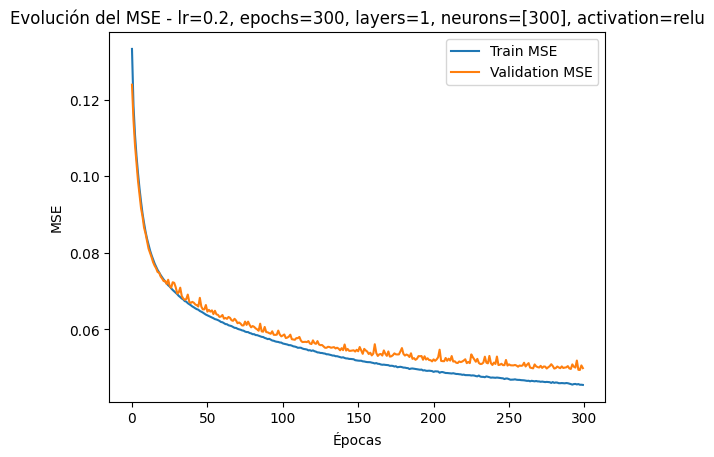

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 382.38389897346497s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 6.75e-02
Época con el menor MSE de validación: 295
MSE de validación mínimo: 6.75e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


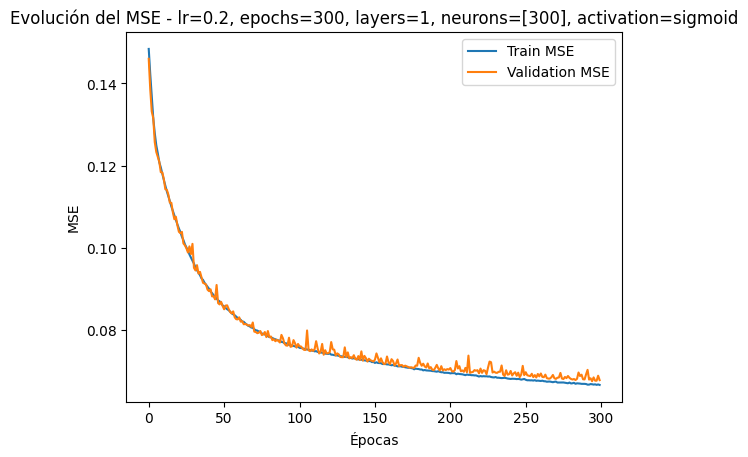

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 336.50958275794983s
304/304 [==============================] - 1s 3ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 1.02e-01
Época con el menor MSE de validación: 299
MSE de validación mínimo: 1.02e-01 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


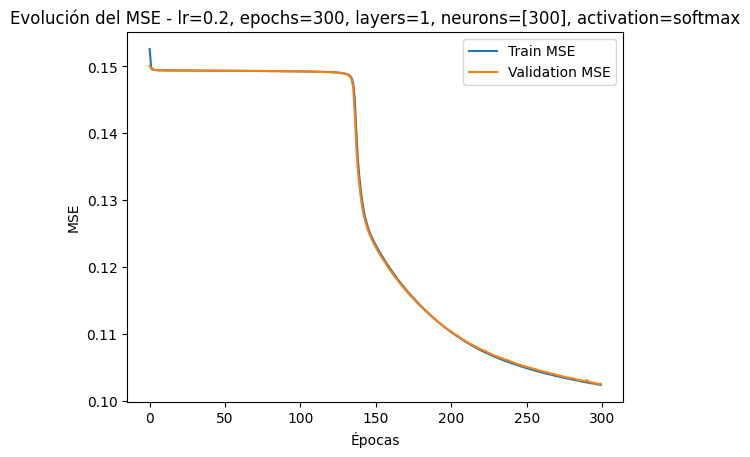

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 252.49940848350525s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 4.72e-02
Época con el menor MSE de validación: 187
MSE de validación mínimo: 4.68e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


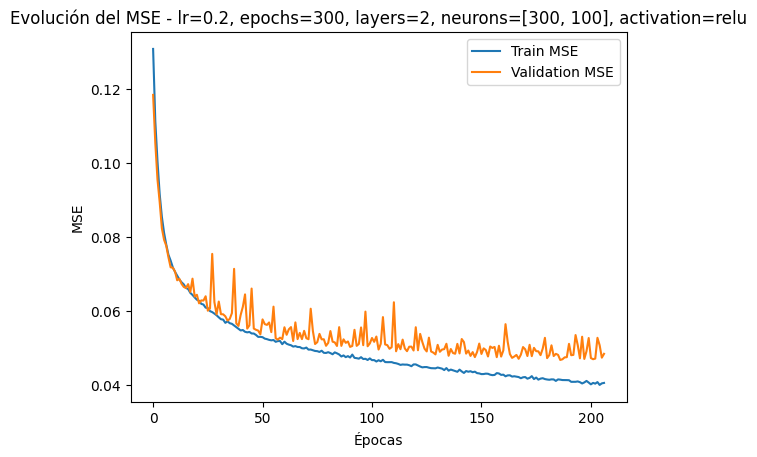

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 382.4322187900543s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 6.22e-02
Época con el menor MSE de validación: 295
MSE de validación mínimo: 6.28e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


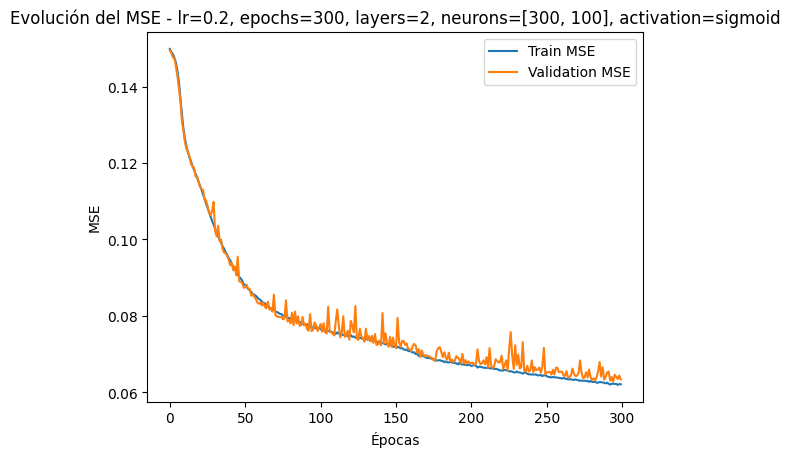

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 74.05504369735718s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 38
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


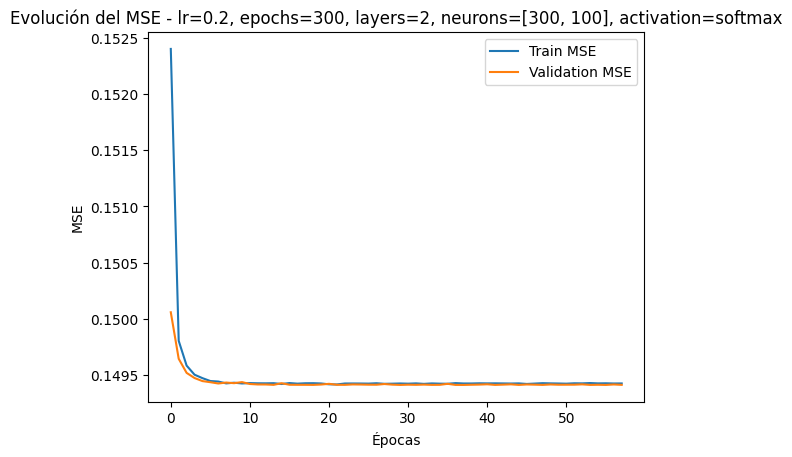

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 236.04665279388428s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.52e-02
Época con el menor MSE de validación: 141
MSE de validación mínimo: 4.52e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


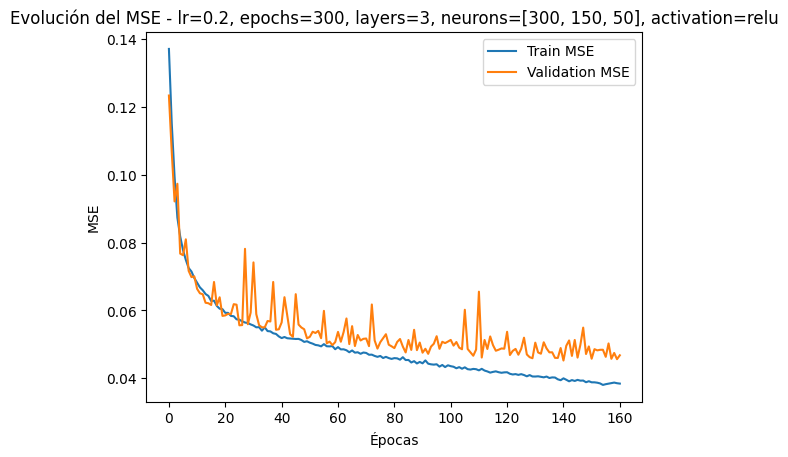

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 465.7364332675934s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 6.37e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 6.40e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


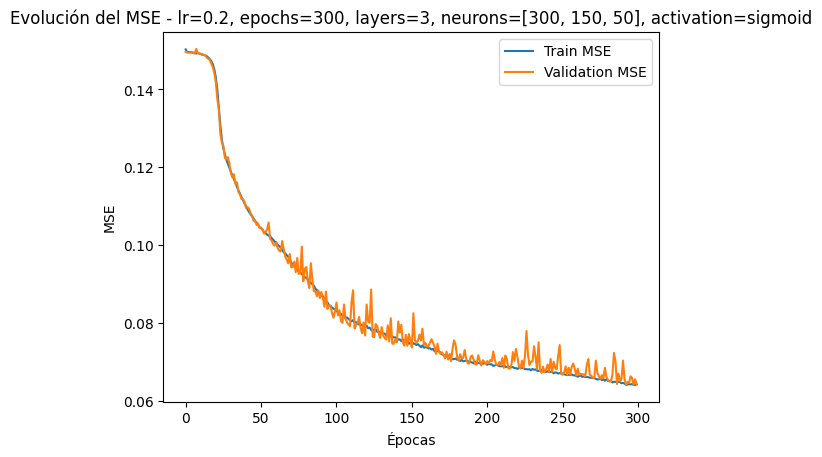

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 89.74599957466125s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 38
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


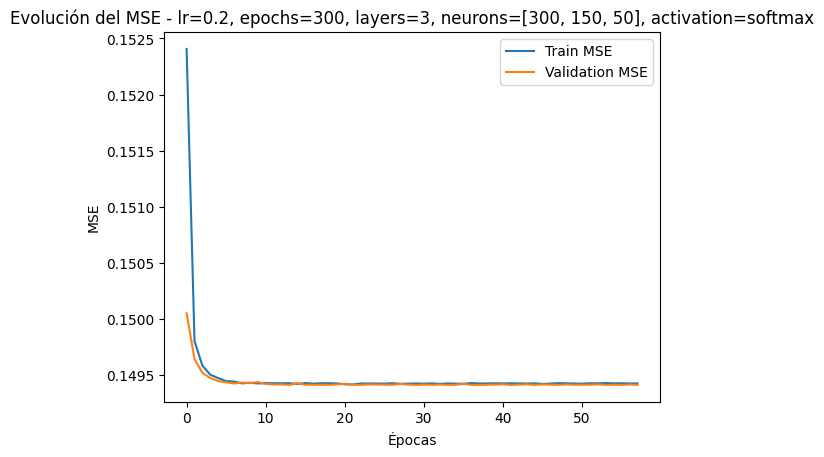

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 328.6771569252014s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 5.41e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 5.41e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


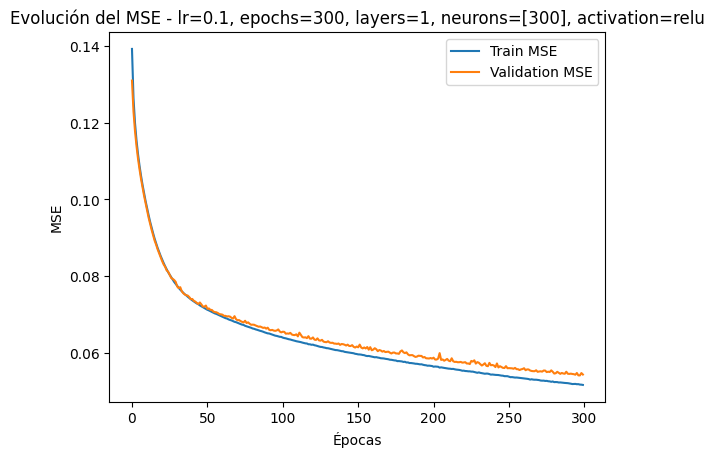

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 382.6600651741028s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 7.22e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 7.20e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


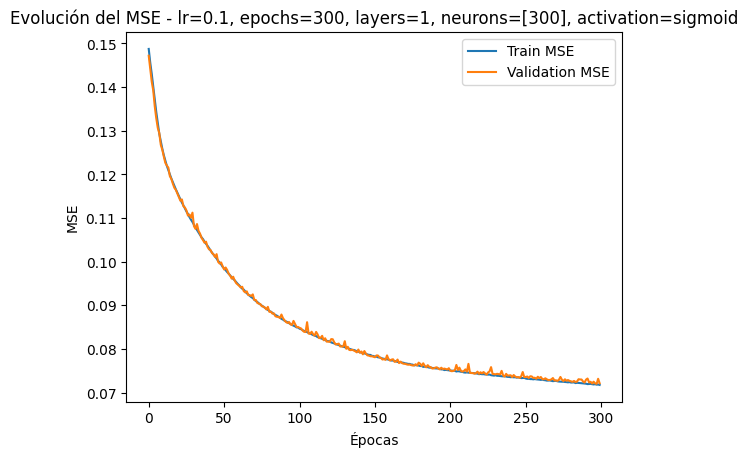

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 382.39484691619873s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 300
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


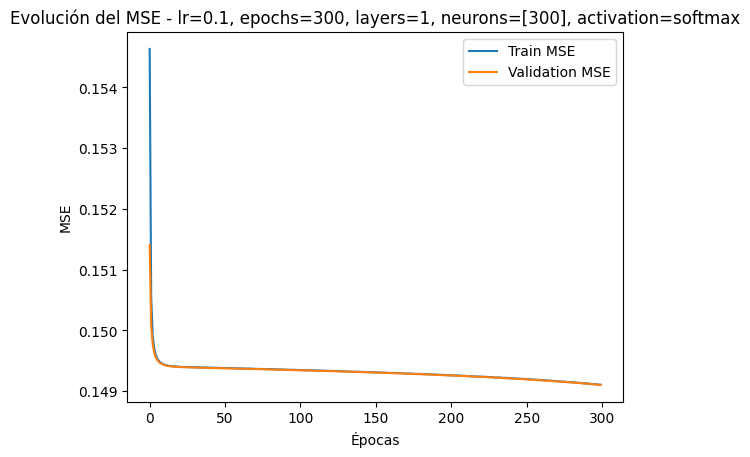

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 158.90561032295227s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 5.13e-02
Época con el menor MSE de validación: 104
MSE de validación mínimo: 5.15e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


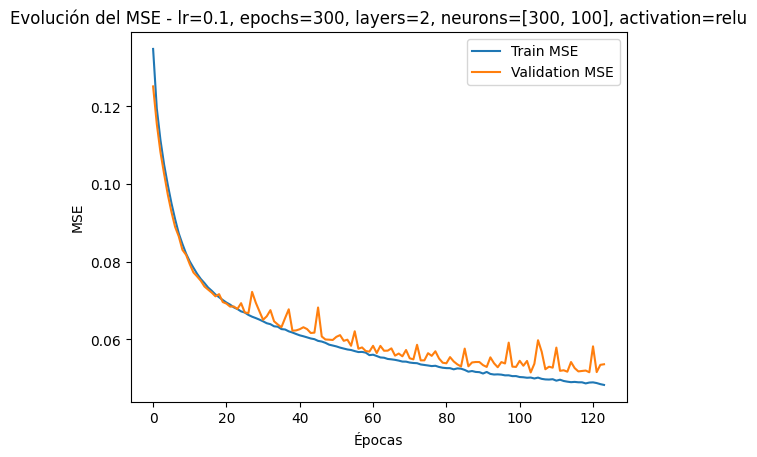

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 382.47153425216675s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 7.24e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 7.19e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


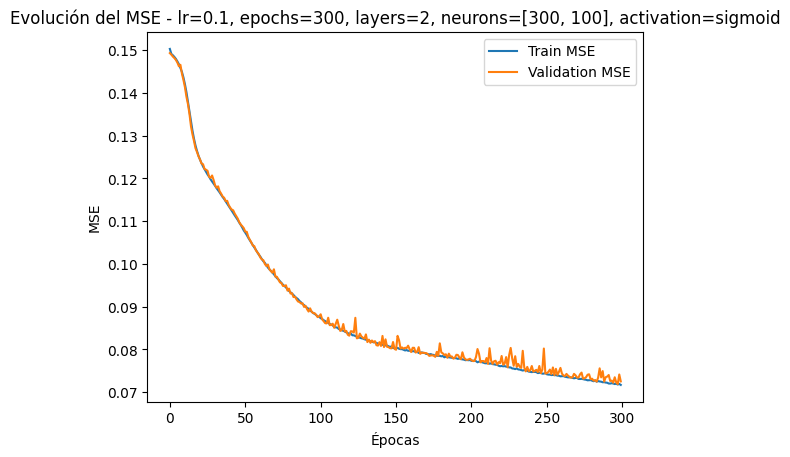

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 97.95023036003113s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 56
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


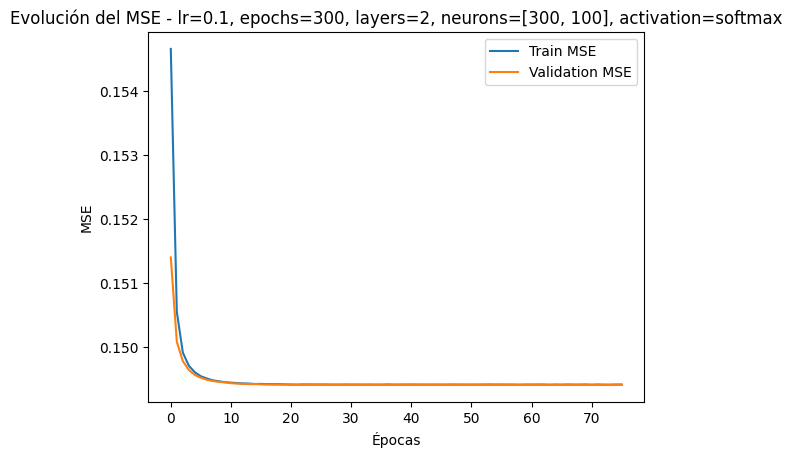

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 276.0220675468445s
304/304 [==============================] - 1s 3ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.66e-02
Época con el menor MSE de validación: 166
MSE de validación mínimo: 4.62e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


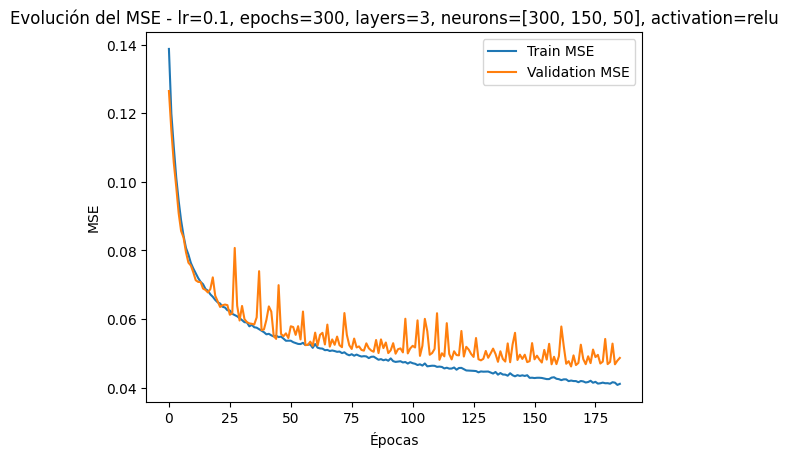

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 502.8871831893921s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 7.52e-02
Época con el menor MSE de validación: 289
MSE de validación mínimo: 7.41e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


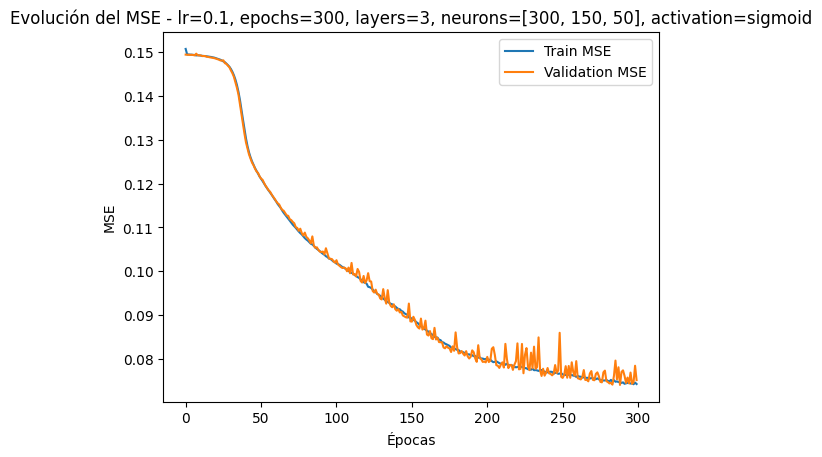

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 118.80786418914795s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 56
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


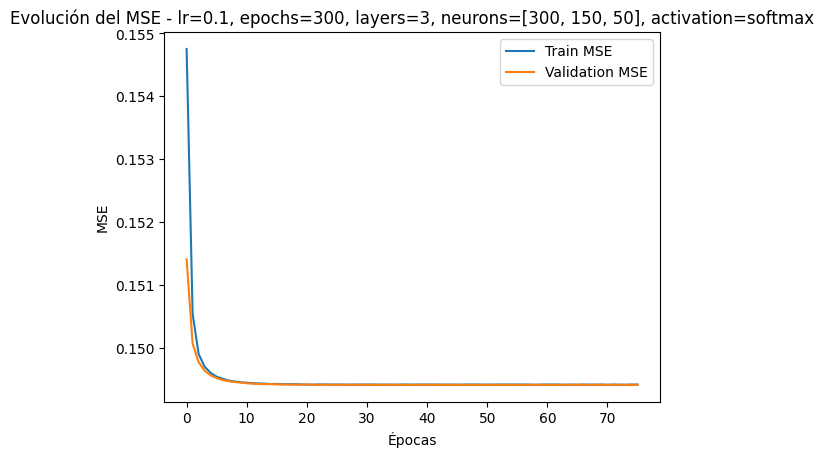

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 382.32848501205444s
304/304 [==============================] - 1s 3ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 6.11e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 6.10e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


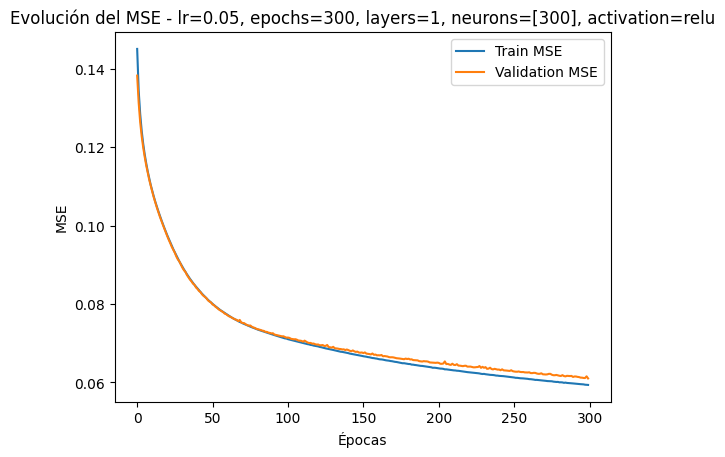

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 332.6292653083801s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 7.86e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 7.83e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


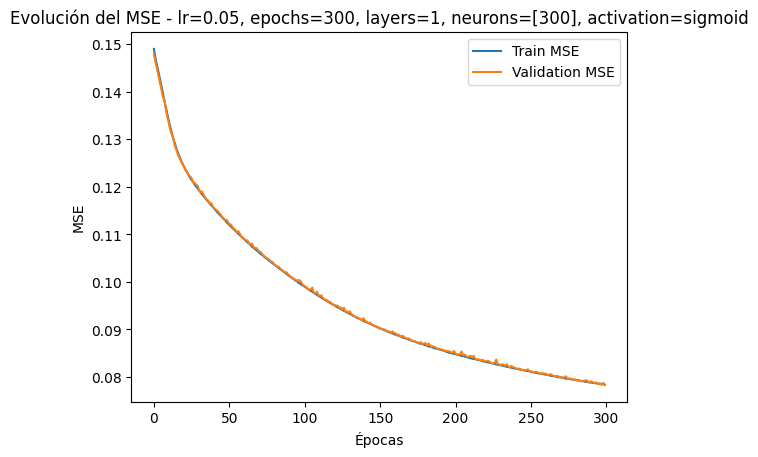

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 382.3665783405304s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 300
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


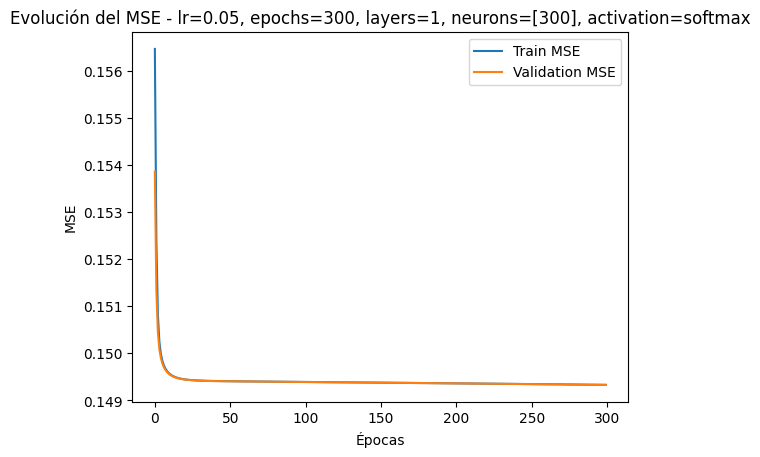

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 382.648642539978s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 4.94e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 4.95e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


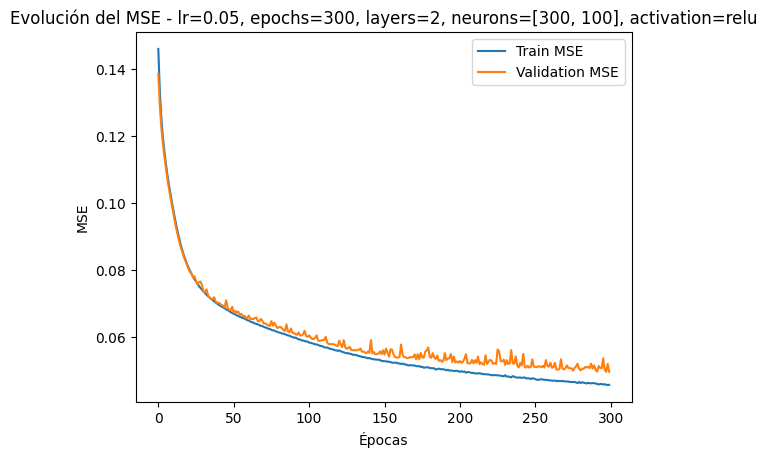

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 382.44476103782654s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 7.98e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 7.96e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


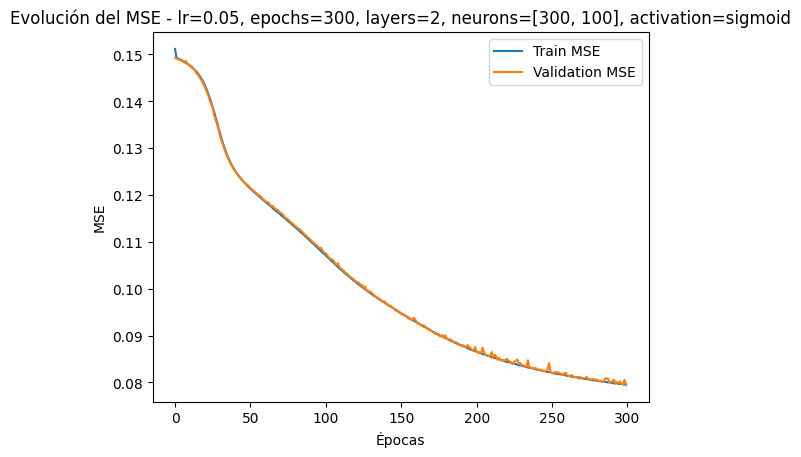

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 155.85648322105408s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 100
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


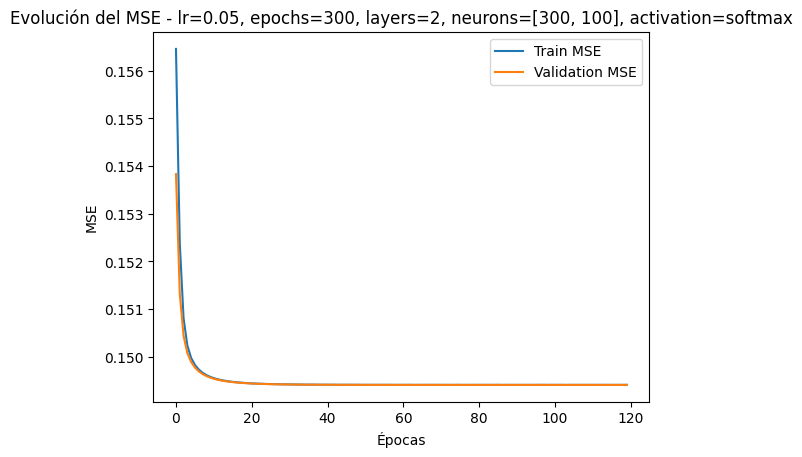

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 502.5028612613678s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.62e-02
Época con el menor MSE de validación: 297
MSE de validación mínimo: 4.63e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


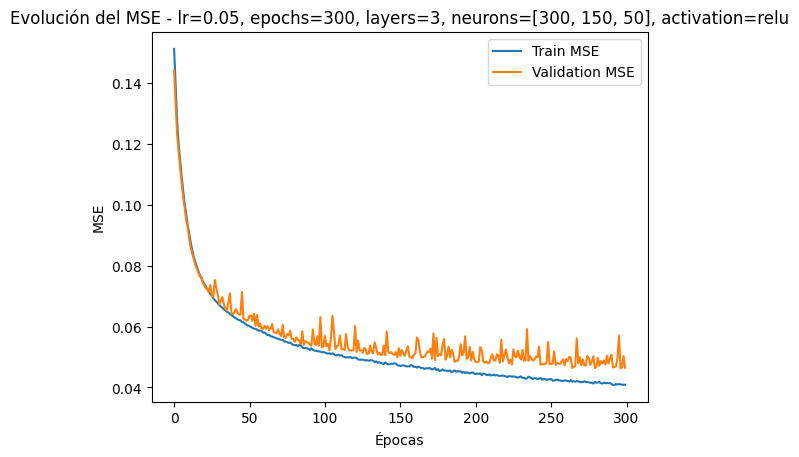

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 475.8137800693512s
304/304 [==============================] - 2s 6ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 9.10e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 9.05e-02 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


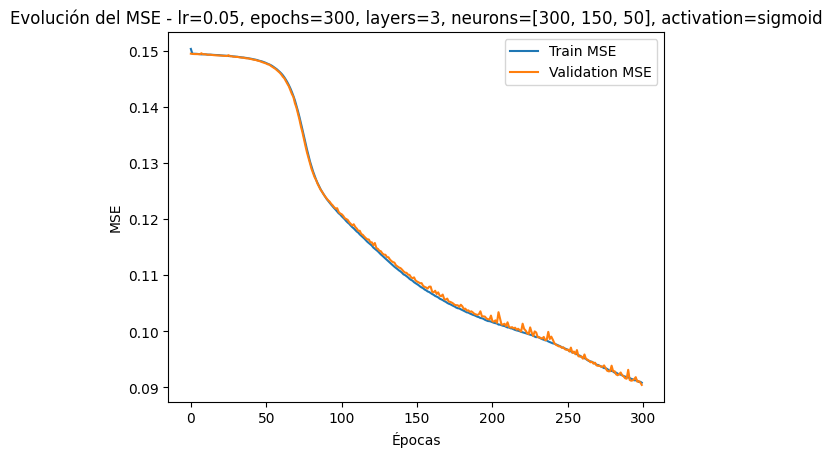

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 212.29944729804993s
304/304 [==============================] - 1s 3ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 114
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-534f5bf90f15>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


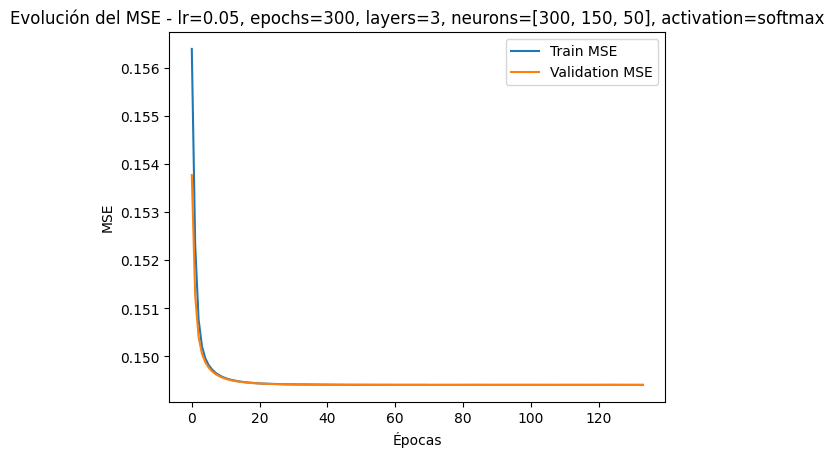

In [14]:
# Definimos las listas de valores para los hiperparámetros
learning_rates = [0.2, 0.1, 0.05]
hidden_layers_list = {1: [100],
                      1: [200],
                      1: [300],
                      2: [60,30],
                      2: [200,75],
                      2: [300,100],
                      3: [50,25,15],
                      3: [200,100,20],
                      3: [300,150,50]}
activation_functions = ['relu', 'sigmoid', 'softmax']
epochs_list = [300]

# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['LR', 'Hidden Layers', 'Neurons', 'Activation Function', 'Epochs', 'Best Epoch', 'Tiempo Entrenamiento', 'Train MSE', 'Validation MSE', 'Test MSE'])

# Iteramos sobre todas las combinaciones de hiperparámetros
for lr in learning_rates:
    for num_hidden_layers, num_neurons in hidden_layers_list.items():  # Utilizamos items() para obtener tanto la clave como el valor del diccionario
        for activation_function in activation_functions:
            for epochs in epochs_list:

                start_time = time.time()
                # Construimos y entrenamos un modelo con los hiperparámetros actuales
                modelo, historico = build_and_train_mlp(lr, num_hidden_layers, num_neurons, activation_function, epochs, patience=20)
                tiempo_total = time.time() - start_time

                # Obtenemos las predicciones
                prediccion = modelo.predict(X_test)
                # Obtenemos el MSE de test
                mse_test = mean_squared_error(y_test, prediccion)
                print(f"MSE de test ((lr = {lr}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {mse_test:.2e}")

                # Obtenemos los errores de entrenamiento y validación
                mse_train = historico.history['loss']
                mse_val = historico.history['val_loss']

                # Encontramos la época en la que el MSE de validación es el menor
                best_epoch = np.argmin(mse_val) + 1

                # Obtenemos el valor mínimo del MSE de entrenamiento
                min_mse_train = np.min(mse_train)
                # Obtenemos el valor mínimo del MSE de validación
                min_mse_val = np.min(mse_val)

                print(f"Época con el menor MSE de validación: {best_epoch}")
                print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

                # Agregamos los resultados a DataFrame
                resultados_df = resultados_df.append({
                    'LR': lr,
                    'Hidden Layers': num_hidden_layers,
                    'Neurons': num_neurons,
                    'Activation Function': activation_function,
                    'Epochs': epochs,
                    'Best Epoch': best_epoch,
                    'Tiempo Entrenamiento': round(tiempo_total,3),
                    'Train MSE': round(min_mse_train,4),
                    'Validation MSE': round(min_mse_val,4),
                    'Test MSE': round(mse_test,4)
                }, ignore_index=True)

                # Graficamos la evolución del MSE durante el entrenamiento
                plt.plot(mse_train, label='Train MSE')
                plt.plot(mse_val, label='Validation MSE')
                plt.title(f'Evolución del MSE - lr={lr}, epochs={epochs}, layers={num_hidden_layers}, neurons={num_neurons}, activation={activation_function}')
                plt.xlabel('Épocas')
                plt.ylabel('MSE')
                plt.legend()
                plt.show()

# Mostrar el DataFrame
resultados_df.to_csv('RESULTADOS_pruebas.csv', index=False)

### 6.3 Elección de los 3 mejores modelos y obtencion de metricas especificas para problemas desbalanceados

Elegimos los 3 modelos con menor error de validación.
- RELU, lr = 0,2, neuronas = [300,150,50] --> val_MSE = 4,52E-02
- RELU, lr = 0,1, neuronas = [300,150,50] --> val_MSE = 4,62E-02
- RELU, lr = 0,05, neuronas = [300,150,50] --> val_MSE = 4,63E-02

A continuación, procederemos a reentrenar los modelos, esta vez configurando un número de épocas más elevado (500) y una paciencia ampliada (50), con el objetivo de evitar quedar atrapados en mínimos locales. Además, calcularemos métricas pertinentes para problemas desbalanceados, tales como precisión (precision), sensibilidad (recall) y puntuación F1 (f1-score).

In [14]:
def entrenar_y_obtener_metricas_desbalanceado(lr, num_hidden_layers, num_neurons, activation_function, epochs, patience, resultados_df, balance_classes=False):
    start_time = time.time()
    # Construimos y entrenamos un modelo con los hiperparámetros actuales
    modelo, historico = build_and_train_mlp(lr, num_hidden_layers, num_neurons, activation_function, epochs, patience=patience, balance_classes=balance_classes)
    tiempo_total = time.time() - start_time

    # Obtenemos las predicciones
    prediccion = modelo.predict(X_test)
    # Obtenemos el MSE de test
    mse_test = mean_squared_error(y_test, prediccion)
    print(f"MSE de test ((lr = {lr}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {mse_test:.2e}")

    # Obtenemos los errores de entrenamiento y validación
    mse_train = historico.history['loss']
    mse_val = historico.history['val_loss']

    # Encontramos la época en la que el MSE de validación es el menor
    best_epoch = np.argmin(mse_val) + 1

    # Obtenemos el valor mínimo del MSE de entrenamiento
    min_mse_train = np.min(mse_train)
    # Obtenemos el valor mínimo del MSE de validación
    min_mse_val = np.min(mse_val)

    print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Sumamos 1 porque las épocas comienzan desde 0
    print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

    # Obtenemos la clase a la que corresponde cada salida (la predicción contiene las probabilidades de pertenecer a cada clase)
    y_pred_classes = np.argmax(prediccion, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Obtenemos las métricas para problemas debsalanceados
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average=None) #average=None para que nos saque el valor para clase
    precision = precision_score(y_test_classes, y_pred_classes, average=None) #average=None para que nos saque el valor para clase
    f1 = f1_score(y_test_classes, y_pred_classes, average=None) #average=None para que nos saque el valor para clase

    # Agregamos los resultados a DataFrame
    resultados_df = resultados_df.append({
      'LR': lr,
      'Neurons': num_neurons,
      'Activation Function': activation_function,
      'Epochs': epochs,
      'Best Epoch': best_epoch,
      'Tiempo': round(tiempo_total, 3),
      'Train MSE': round(min_mse_train,4),
      'Validation MSE': round(min_mse_val,4),
      'Test MSE': round(mse_test,4),
      'Accuracy': round(accuracy,3),
      'Recall': np.round(recall,3).tolist(),
      'Precision': np.round(precision,3).tolist(),
      'F1_score': np.round(f1,3).tolist()
    }, ignore_index=True)

    # Graficamos la evolución del MSE durante el entrenamiento
    plt.plot(mse_train, label='Train MSE')
    plt.plot(mse_val, label='Validation MSE')
    plt.title(f'Evolución del MSE - lr={lr}, epochs={epochs}, layers={num_hidden_layers}, neurons={num_neurons}, activation={activation_function}')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    return resultados_df

Tiempo de entrenamiento para (lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 435.9755594730377s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.41e-02
Época con el menor MSE de validación: 259
MSE de validación mínimo: 4.37e-02 



<ipython-input-14-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


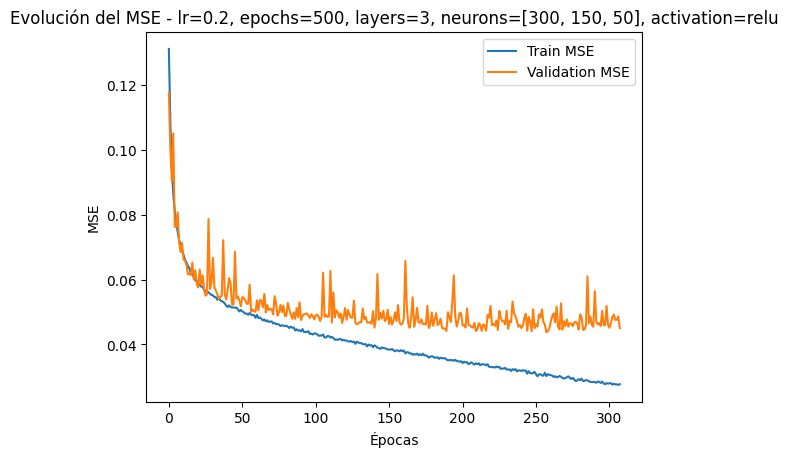

Tiempo de entrenamiento para (lr = 0.1, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 454.5331735610962s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.52e-02
Época con el menor MSE de validación: 266
MSE de validación mínimo: 4.45e-02 



<ipython-input-14-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


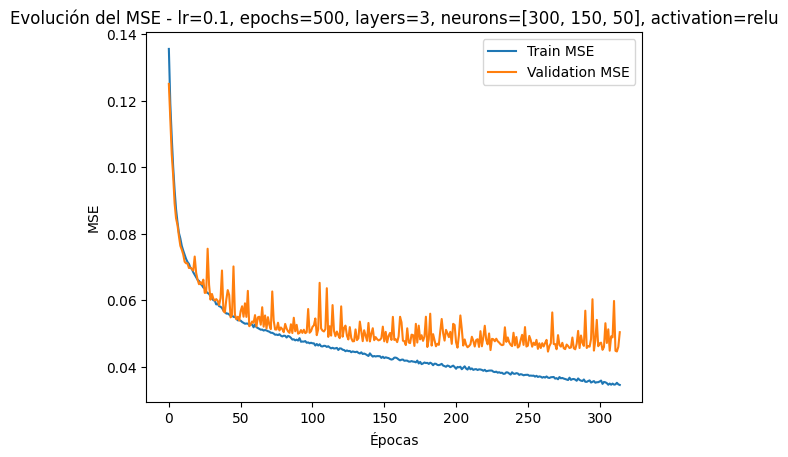

Tiempo de entrenamiento para (lr = 0.05, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 742.5286998748779s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 5.00e-02
Época con el menor MSE de validación: 457
MSE de validación mínimo: 4.46e-02 



<ipython-input-14-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


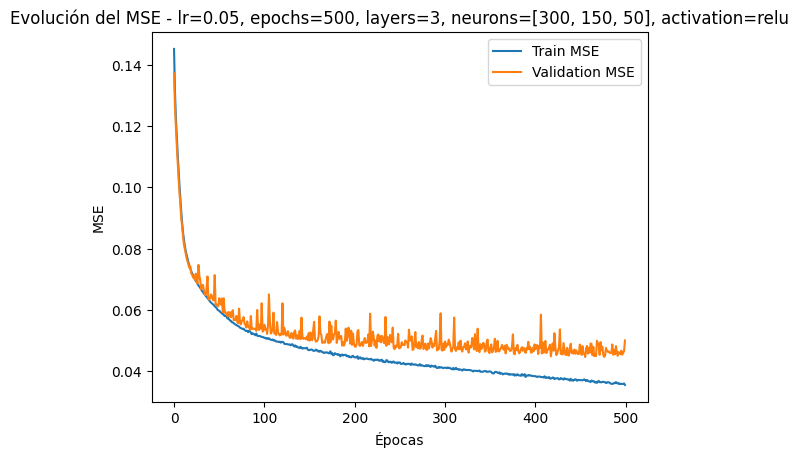

In [15]:
# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['LR', 'Neurons', 'Activation Function', 'Epochs', 'Best Epoch', 'Tiempo', 'Train MSE', 'Validation MSE', 'Test MSE', 'Accuracy', 'Recall', 'Precision', 'F1_score'])

resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.2, num_hidden_layers=3, num_neurons=[300,150,50], activation_function='relu', epochs=500, patience=50, resultados_df=resultados_df)
resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.1, num_hidden_layers=3, num_neurons=[300,150,50], activation_function='relu', epochs=500, patience=50, resultados_df=resultados_df)
resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.05, num_hidden_layers=3, num_neurons=[300,150,50], activation_function='relu', epochs=500, patience=50, resultados_df=resultados_df)

resultados_df.to_csv('RESULTADOS_mejores_modelos.csv', index=False)

### 6.3 Exploración con balanceo (weights)

Los entrenamos otra vez incluyendo el balanceo de clases. Analizamos la influencia que tiene esta técnica de balanceo.

Tiempo de entrenamiento para (lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 340.0354235172272s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.63e-02
Época con el menor MSE de validación: 172
MSE de validación mínimo: 4.54e-02 



<ipython-input-14-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


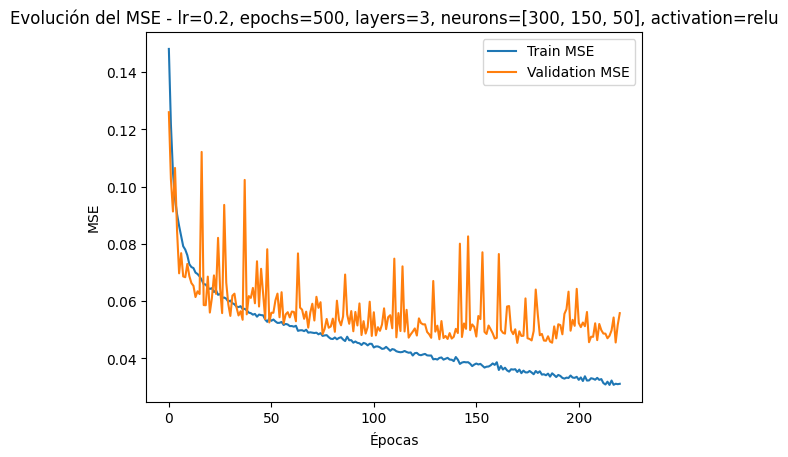

Tiempo de entrenamiento para (lr = 0.1, epoch = 500, num_hidden_layers=3, num_neurons=[300, 100, 50], activation_function=relu): 507.80180311203003s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 500, num_hidden_layers=3, num_neurons=[300, 100, 50], activation_function=relu): 4.54e-02
Época con el menor MSE de validación: 320
MSE de validación mínimo: 4.40e-02 



<ipython-input-14-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


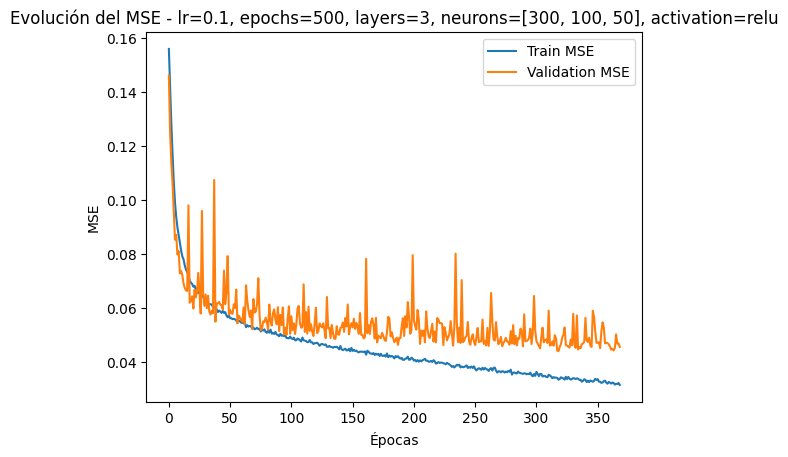

Tiempo de entrenamiento para (lr = 0.05, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 392.4810016155243s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.86e-02
Época con el menor MSE de validación: 207
MSE de validación mínimo: 4.78e-02 



<ipython-input-14-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


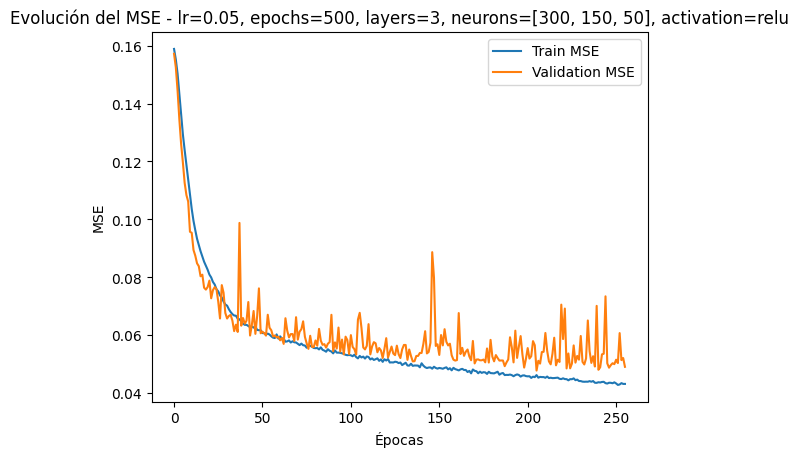

In [16]:
# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['LR', 'Neurons', 'Activation Function', 'Epochs', 'Best Epoch', 'Tiempo', 'Train MSE', 'Validation MSE', 'Test MSE', 'Accuracy', 'Recall', 'Precision', 'F1_score'])

resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.2, num_hidden_layers=3, num_neurons=[300,150,50], activation_function='relu', epochs=500, patience=50, balance_classes = True, resultados_df=resultados_df)
resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.1, num_hidden_layers=3, num_neurons=[300,100,50], activation_function='relu', epochs=500, patience=50, balance_classes = True, resultados_df=resultados_df)
resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.05, num_hidden_layers=3, num_neurons=[300,150,50], activation_function='relu', epochs=500, patience=50, balance_classes = True, resultados_df=resultados_df)

resultados_df.to_csv('RESULTADOS_balanceo_mejores_modelos.csv', index=False)

### 6.3 Construimos el modelo final
Para la elección del modelo final, no sólo nos fijaremos en el error de validación, sino que tendremos en cuenta las métricas de precisión, recall, accuracy y f1-score sobre el conjunto de validación puesto que estamos ante un problema desbalanceado.

Analizando los resultados obtenidos, podemos observar que son realmente similares. Tanto los modelos con balanceo como sin, son capaces de clasificar correctamente la mayoría de muestras de cada clase. Es decir, todos los modelos nos dan buenos resultados de recall, precision, accuracy y f1-score.

Por esta razón, vamos a escoger el modelo que maximice el f1-score (que relaciona el recall y la precision) y el accuracy.

Este modelo es el siguiente:


*   RELU, lr = 0,1, neuronas = [300,150,50], balance_classes = False

Sorprendentemente, es un modelo que no experimenta un balanceo de clases por medio de la inclusión de pesos.

Lo entrenamos con los datos de validación y train.


Primero, juntamos los datos de train y validation con el número de épocas que minimiza el error de validación, 265.

In [14]:
# Combinamos los conjuntos de entrenamiento y validación
X_train_final = np.concatenate((X_train, X_validation), axis=0)
y_train_final = np.concatenate((y_train, y_validation), axis=0)

In [16]:
input_shape=(X_train_final.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla.

# ESPECIFICAR LOS HIPERPARAMETROS CUANDO LOS TENGAMOS
modelo_final = Sequential()

# Capa de entrada
modelo_final.add(Dense(300, activation='relu', input_shape=input_shape))

# Capas ocultas
modelo_final.add(Dense(150, activation='relu'))
modelo_final.add(Dense(50, activation='relu'))

# Capa de salida (5 clases --> 5 neuronas)
modelo_final.add(Dense(5, activation='softmax'))

modelo_final.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0), metrics=['mse'])

start_time = time.time()
# Entrenamos el modelo, incluyendo o no el balanceo de clases según el parámetro
historico = modelo_final.fit(X_train_final, y_train_final, epochs=265, batch_size=32)
tiempo_total = time.time() - start_time
print(f"Tiempo de entrenamiento para (lr = {0.1}, epoch = {265}, num_hidden_layers={3}, num_neurons={[300,150,50]}, activation_function={'relu'}): {tiempo_total}s")

# Guardamos los pesos del modelo
modelo_final.save_weights('pesos.h5')


Epoch 1/265
608/608 [==============================] - 10s 9ms/step - loss: 0.1441 - mse: 0.1441
Epoch 2/265
608/608 [==============================] - 7s 12ms/step - loss: 0.1207 - mse: 0.1207
Epoch 3/265
608/608 [==============================] - 2s 3ms/step - loss: 0.1080 - mse: 0.1080
Epoch 4/265
608/608 [==============================] - 2s 3ms/step - loss: 0.0980 - mse: 0.0980
Epoch 5/265
608/608 [==============================] - 2s 3ms/step - loss: 0.0898 - mse: 0.0898
Epoch 6/265
608/608 [==============================] - 1s 2ms/step - loss: 0.0834 - mse: 0.0834
Epoch 7/265
608/608 [==============================] - 1s 2ms/step - loss: 0.0788 - mse: 0.0788
Epoch 8/265
608/608 [==============================] - 2s 3ms/step - loss: 0.0756 - mse: 0.0756
Epoch 9/265
608/608 [==============================] - 2s 3ms/step - loss: 0.0731 - mse: 0.0731
Epoch 10/265
608/608 [==============================] - 3s 4ms/step - loss: 0.0715 - mse: 0.0715
Epoch 11/265
608/608 [===============

### 6.4 Error y métricas sobre los datos de test y predicciones
Realizamos las predicciones sobre los datos de test (X_test) y las evaluamos con la variable de respuesta de test (y_test).

In [20]:
# Predecimos sobre el conjunto de prueba
y_pred = modelo_final.predict(X_test)

# Convertimos las predicciones a clases
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Creamos un DataFrame con las clases predichas y las clases reales
resultados_df = pd.DataFrame({'Clase Predicha': y_pred_classes, 'Clase Real': y_test_classes})

# Ordenamos los valores reales de menor a mayor
resultados_df = resultados_df.sort_values(by='Clase Real')

# Guardamos el DataFrame como un archivo de texto
resultados_df.to_csv('predicciones_y_deseados.txt', index=False, sep='\t')

# Calculamos y mostrar las métricas
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average=None)
recall = recall_score(y_test_classes, y_pred_classes, average=None)
f1 = f1_score(y_test_classes, y_pred_classes, average=None)
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {np.round(precision,3).tolist()}')
print(f'Recall: {np.round(recall,3).tolist()}')
print(f'F1 Score: {np.round(f1,3).tolist()}')
print('Confusion Matrix:')
print(conf_matrix)


304/304 [==============================] - 1s 2ms/step
Accuracy: 0.854
Precision: [0.861, 0.823, 0.893, 0.837, 0.808]
Recall: [0.911, 0.819, 0.834, 0.809, 0.801]
F1 Score: [0.885, 0.821, 0.862, 0.823, 0.804]
Confusion Matrix:
[[3308  257   41   14   13]
 [ 287 1512   18   26    4]
 [ 113   30 1823  157   63]
 [ 114   29  106 1188   31]
 [  19    9   54   34  467]]


Comparamos las predicciones con los valores reales gráficamente.

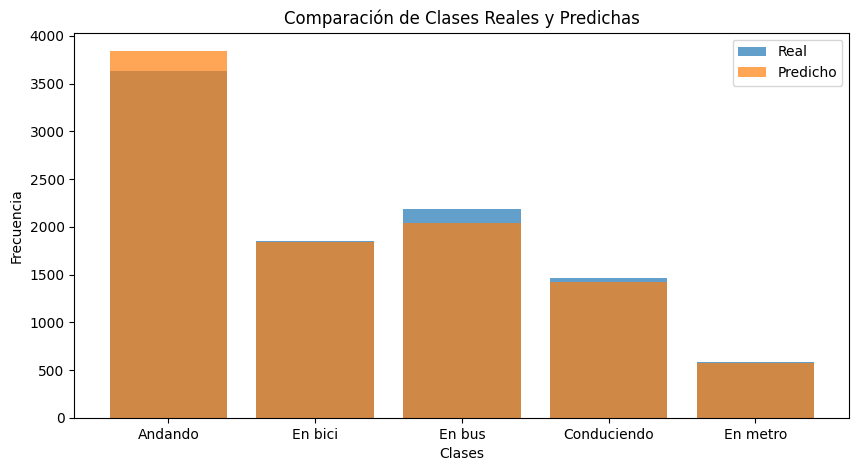

In [21]:
# Definir etiquetas de clases
class_labels = ['Andando', 'En bici', 'En bus', 'Conduciendo', 'En metro']

# Crear un gráfico de barras para las clases reales
plt.figure(figsize=(10, 5))
plt.bar(class_labels, np.bincount(y_test_classes), label='Real', alpha=0.7)

# Crear un gráfico de barras para las clases predichas
plt.bar(class_labels, np.bincount(y_pred_classes), label='Predicho', alpha=0.7)

plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.title('Comparación de Clases Reales y Predichas')
plt.legend()
plt.show()